In [6]:
'''
03_network.ipynb
Calculate network metrices - centr_eigen, centr_closes, centr_infos, centr_between
'''

import pathlib
import os
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
import folium
import networkx as nx
import matplotlib.pyplot as plt

# needs for projections
from pyproj import CRS
crs=CRS('EPSG:4326')

tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", 
	"attribution": '',
}

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../..' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'
DIR_PATHS = DIR_ROOT + '/data/03_paths/'

paths = gpd.read_file(DIR_PATHS + 'paths.geojson').to_dict('records')
activities_df = pd.read_csv(DIR_DATA + 'activities.csv')

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)
stays_df.set_index('locality', inplace=True)
stays_df['locality'] = stays_df.index

stays_geo = gpd.GeoDataFrame(stays_df, crs=crs).set_geometry('geometry')

localities = stays_geo[stays_geo['domestic'] == True].groupby(level=0).first()
localities['name'] = localities.index

bbox = stays_geo.buffer(1).total_bounds

/tmp/ipykernel_80167/2634183136.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = stays_geo.buffer(1).total_bounds


In [7]:
edges = []
for this_stay_no in range(len(stays_df) - 1):
    this_stay = stays_df.iloc[this_stay_no]
    next_stay = stays_df.iloc[this_stay_no + 1]

    if this_stay['locality'] != next_stay['locality']:
        locality_from = this_stay['locality'] if this_stay['locality'] < next_stay['locality'] else next_stay['locality']
        locality_to = this_stay['locality'] if this_stay['locality'] > next_stay['locality'] else next_stay['locality']

        edges.append(
            {
                "f": locality_from,
                "t": locality_to,
                "domestic": next_stay['domestic'] == True,
                "period1": next_stay['period1'],
                "period2": next_stay['period2'],
                "period3": next_stay['period3'],
                "period4": next_stay['period4'],
                "period5": next_stay['period5'],
                "periodall": True,
            }
        )

periods = ['1', '2', '3', '4', '5', 'all']

In [8]:
# construct graph and calculate centralities

eigens = []
infos = []
closes = []
between = []

for period in periods:

    G = nx.Graph()
    
    for i1, l1 in localities.iterrows():
        for i2, l2 in localities.iterrows():
            if i1 > i2:
                es = [
                    e for e in edges if (e['f'] == i2) & (e['t'] == i1) & (e['domestic'] == True) & (e['period' + period] == True)
                ]
                if len(es) > 0:
                    distance = next(path for path in paths if path['from'] == l1['name'] and path['to'] == l2['name'])
                    G.add_edge(i1, i2, weight=len(es), distance=float(distance['dist']))

    between.append(pd.DataFrame(list(
        nx.algorithms.betweenness_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))
    
    closes.append(pd.DataFrame(list(
        nx.algorithms.closeness_centrality(G, distance="distance", wf_improved=True).items()
    ), columns=['name', 'p' + period]).set_index('name'))

    eigens.append(pd.DataFrame(list(
        nx.algorithms.eigenvector_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))

    infos.append(pd.DataFrame(list(
        nx.algorithms.information_centrality(G, weight="weight").items()
    ), columns=['name', 'p' + period]).set_index('name'))


    print('p{} processed'.format(period))

p1 processed
p2 processed
p3 processed
p4 processed
p5 processed
pall processed


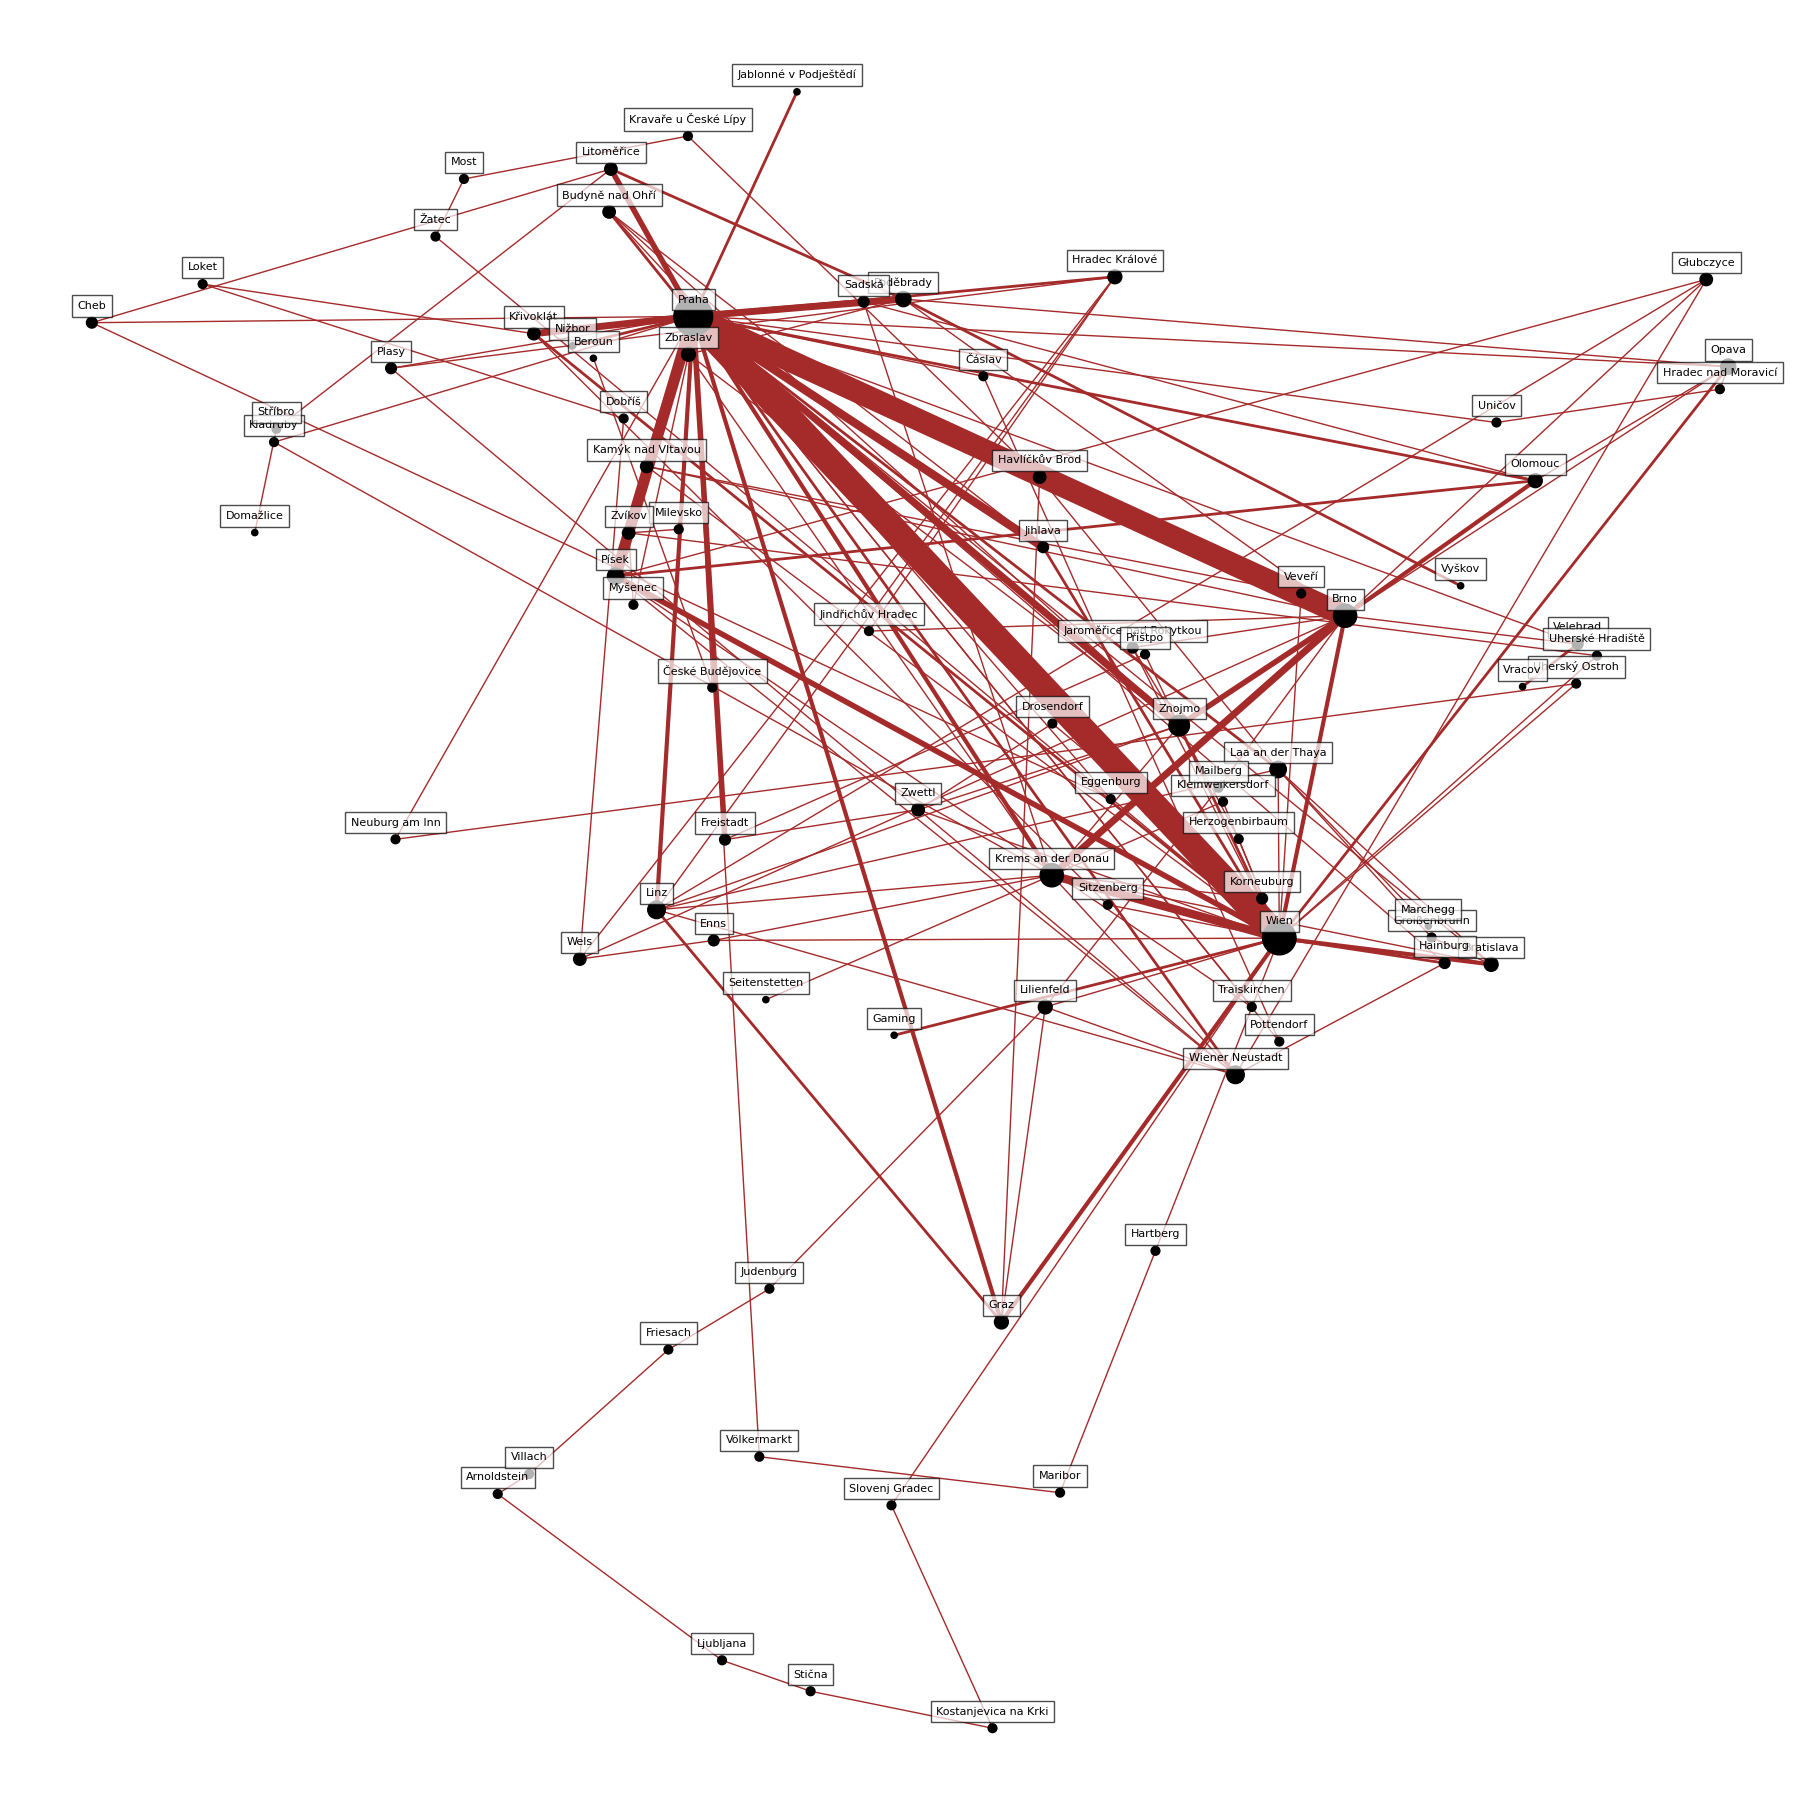

In [16]:
labels_pos = {name: [geo.x, geo.y + 0.05] for (name, geo) in localities[['geometry']].itertuples()}
node_pos = {name: [geo.x, geo.y] for (name, geo) in localities[['geometry']].itertuples()}
edge_weights = nx.get_edge_attributes(G,'weight').values()
node_degree = nx.degree(G)

plt.figure(figsize=(18,18))
nx.draw(G, pos=node_pos, width=list(edge_weights), node_size=[v[1] * 20 for v in node_degree], node_color='black', edge_color="brown")
nx.draw_networkx_labels(G, pos=labels_pos, font_size=8, font_color='black', bbox=dict(facecolor='white', alpha=0.7))
plt.show()

In [10]:
closes_df = gpd.GeoDataFrame(
    pd.concat(closes + [localities['geometry']], axis=1, join="outer"),
    crs=crs
)

eigen_df = gpd.GeoDataFrame(
    pd.concat(eigens + [localities['geometry']], axis=1, join="outer"),
    crs=crs
)

info_df = gpd.GeoDataFrame(
    pd.concat(infos + [localities['geometry']], axis=1, join="outer"),
    crs=crs
)

between_df = gpd.GeoDataFrame(
    pd.concat(between + [localities['geometry']], axis=1, join="outer"),
    crs=crs
)

closes_df.to_csv(DIR_OUT + 'centr_closes.csv')
eigen_df.to_csv(DIR_OUT + 'centr_eigen.csv')
info_df.to_csv(DIR_OUT + 'centr_infos.csv')
between_df.to_csv(DIR_OUT + 'centr_between.csv')

In [17]:
def create_map():
    m = folium.Map(dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )

In [18]:
map = create_map()

for location_name, r in closes_df.iterrows():
    create_circle(
        r['pall'] * 100, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

In [19]:
map = create_map()

for location_name, r in between_df.iterrows():
    create_circle(
        r['pall'] * 100, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

In [20]:
map = create_map()

for location_name, r in eigen_df.iterrows():
    create_circle(
        r['pall'] * 30 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

In [21]:
map = create_map()

for location_name, r in info_df.iterrows():
    create_circle(
        r['pall'] * 400, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map